In [1]:
# !pip3 install ipympl

In [2]:
import matplotlib.colors as colors
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# 1. Plot util functions
This section provides some utils we might use later

In [3]:
def plot_decision_boundaries(X, centers, iter, resolution=1000):
    mins = X.min(axis=0) - 1
    maxs = X.max(axis=0) + 1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = kmeans_assign_labels(np.c_[xx.ravel(), yy.ravel()], centers)
    Z = Z.reshape(xx.shape)

    cmap = colors.ListedColormap(['b','g','r'])
    bounds = [0,0.9,1.1,1.9]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    plt.imshow(Z, extent=(mins[0], maxs[0], maxs[1], mins[1]),
               interpolation='none', cmap=cmap, norm=norm, alpha=.3)
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=.5, colors='k')
    plt.xlabel(f"iteration: {iter}")

def kmeans_display(X, iter, label, centers):
    plt.clf()
    K = np.amax(label) + 1
    X0 = X[label == 0, :]
    X1 = X[label == 1, :]
    X2 = X[label == 2, :]

    plt.plot(X0[:, 0], X0[:, 1], 'b^', markersize=4, alpha=.8,mec='k',mew=.5)
    plt.plot(X1[:, 0], X1[:, 1], 'go', markersize=4, alpha=.8,mec='k',mew=.5)
    plt.plot(X2[:, 0], X2[:, 1], 'rs', markersize=4, alpha=.8,mec='k',mew=.5)

    shape = centers.shape[0]
    if shape > 0:
        plt.plot(centers[0, 0], centers[0, 1], 'y^', markersize=10, alpha=1,mec='k',mew=.6)
    if shape > 1:
        plt.plot(centers[1, 0], centers[1, 1], 'yo', markersize=10, alpha=1,mec='k',mew=.6)
    if shape > 2:
        plt.plot(centers[2, 0], centers[2, 1], 'ys', markersize=10, alpha=1,mec='k',mew=.6)
    # plot the voronoi diagram
    plot_decision_boundaries(X, centers, iter)

    # init plot
    # plt.axis('equal')
    plt.plot()
    plt.draw()
    plt.pause(2)


# 2. K-means Lloyd iteration

In [4]:
def kmeans_assign_labels(X, centers):
    # calculate pairwise distances btw data and centers
    D = cdist(X, centers)
    # return index of the closest center
    return np.argmin(D, axis = 1)

def kmeans_update_centers(X, labels, K):
    centers = np.zeros((K, X.shape[1]))
    for k in range(K):
        # collect all points assigned to the k-th cluster
        Xk = X[labels == k, :]
        # take average
        centers[k,:] = np.mean(Xk, axis = 0)
    return centers

def has_converged(centers, new_centers):
    # return True if two sets of centers are the same
    return (set([tuple(a) for a in centers]) ==
        set([tuple(a) for a in new_centers]))

# 3. Initialization methods

In [5]:
def kmeans_random_init(X, k):
    # randomly pick k rows of X as initial centers
    return X[np.random.choice(X.shape[0], k, replace=False)]

def kmeans_pp_init(X, k):
    # perform k-means++ initialization
    # randomly choose first centroid
    centers = []
    centers.append(X[np.random.randint(X.shape[0]), :])

    D = cdist(X, centers, 'sqeuclidean') # squared distance vector
    loss = D.sum() # current loss
    label = np.array([0]*D.size)
    kmeans_display(X, 0, label, np.array(centers))

    for i in range(1, k):
        # Choose a center candidate by sampling with probability proportional
        # to the squared distance to the closest existing center
        rand_val = np.random.uniform(size=1) * loss
        new_center = np.searchsorted(np.cumsum(D), rand_val)
        # XXX: numerical imprecision can result in new_center out of range
        np.clip(new_center, None, D.size - 1, out=new_center)

        # Compute distances to new center
        new_dist = cdist(X, X[new_center], 'sqeuclidean')

        # update closest distances squared, label, and loss value
        for j in range(D.size):
            if new_dist[j] < D[j]:
                label[j] = i # update label
                D[j] = new_dist[j] # update distance
        loss = D.sum()
        # update centers
        centers.append(X[new_center][0])

        kmeans_display(X, 0, label, np.array(centers))
    return np.array(centers)

# 4. The whole algorithm

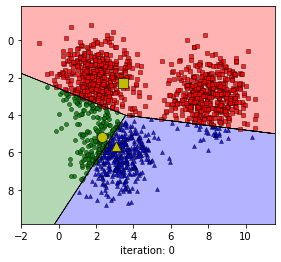

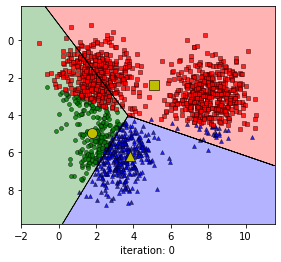

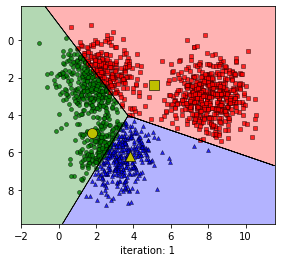

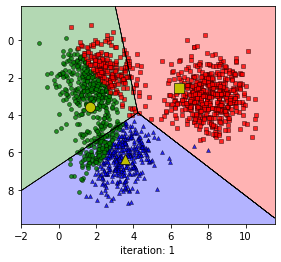

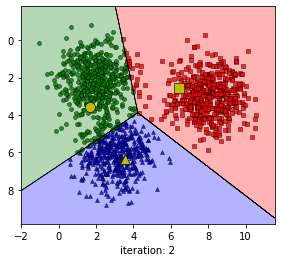

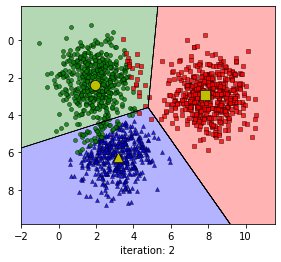

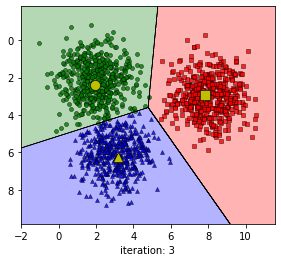

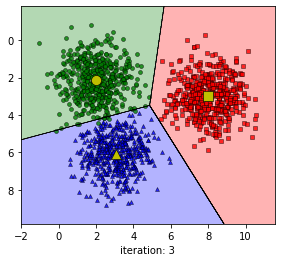

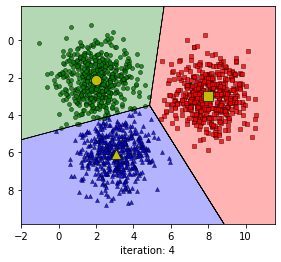

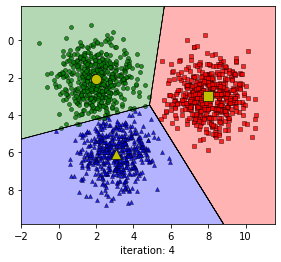

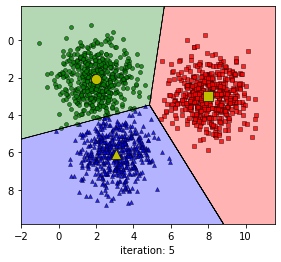

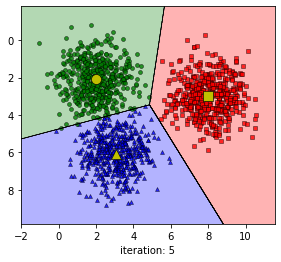

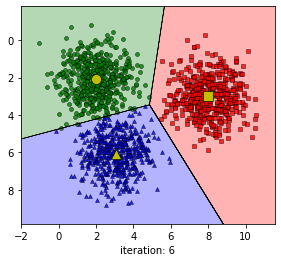

Centers found by our algorithm:
[[3.04730828 6.06967582]
 [1.98663699 2.08159555]
 [8.0147519  2.99404044]]


In [6]:
# TO SHOW INTERACTIVE PLOT
# %matplotlib widget
# from google.colab import output
# output.enable_custom_widget_manager() 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

# 281 creates bad cluster
np.random.seed(211)

means = [[2, 2], [8, 3], [3, 6]]
cov = [[1, 0], [0, 1]]
N = 500
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X2 = np.random.multivariate_normal(means[2], cov, N)

X = np.concatenate((X0, X1, X2), axis = 0)
K = 3

original_label = np.asarray([0]*N + [1]*N + [2]*N).T

def kmeans(X, K):
    plt.ion()
    fig = plt.figure()
    # fig.canvas.mpl_connect('close_event', handle_close)

    # set initialization mode here
    centers = [kmeans_random_init(X, K)]
    # centers = [kmeans_pp_init(X, K)]
    labels = []
    it = 0
    while True:
        labels.append(kmeans_assign_labels(X, centers[-1])) # update new labels
        kmeans_display(X, it, labels[-1], centers[-1])

        new_centers = kmeans_update_centers(X, labels[-1], K)
        if has_converged(centers[-1], new_centers):
            break
        centers.append(new_centers)
        kmeans_display(X, it, labels[-1], centers[-1])
        it += 1
    return (centers, labels, it)

(centers, labels, it) = kmeans(X, K)
print('Centers found by our algorithm:')
print(centers[-1])